#Importing files/Libraries

In [315]:
import os
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from itertools import cycle
import seaborn as sns

pyplot.style.use('seaborn-darkgrid')

In [316]:
data=pd.read_csv("/content/bitcoindat.csv",index_col='Date',parse_dates=True)

#Exploratory Data Analysis

In [317]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1556 entries, 2017-07-31 to 2013-04-28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1556 non-null   float64
 1   High        1556 non-null   float64
 2   Low         1556 non-null   float64
 3   Close       1556 non-null   float64
 4   Volume      1556 non-null   object 
 5   Market Cap  1556 non-null   object 
dtypes: float64(4), object(2)
memory usage: 85.1+ KB


In [318]:
data.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
2017-07-30,2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2017-07-29,2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
2017-07-28,2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
2017-07-27,2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


In [319]:
data['Close']

Date
2017-07-31    2875.34
2017-07-30    2757.18
2017-07-29    2726.45
2017-07-28    2809.01
2017-07-27    2671.78
               ...   
2013-05-02     105.21
2013-05-01     116.99
2013-04-30     139.00
2013-04-29     144.54
2013-04-28     134.21
Name: Close, Length: 1556, dtype: float64

In [320]:
f = px.line(data,x=data.index,y=data['Close'],labels={ 'Date','Close price'})
f.show(renderer="colab")

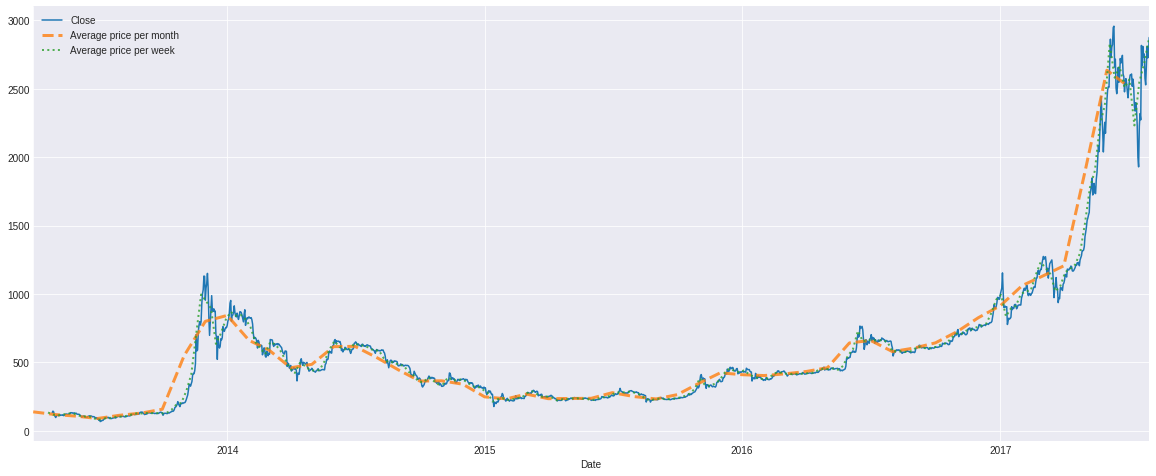

In [321]:
pyplot.figure(figsize=(20,8))
data['Close'].plot()
data['Close'].resample('M').mean().plot(label='Average price per month',lw=3,ls='--',alpha=0.8)
data['Close'].resample('W').mean().plot(label='Average price per week',lw=2,ls=':',alpha=0.8)
pyplot.legend()
pyplot.show()

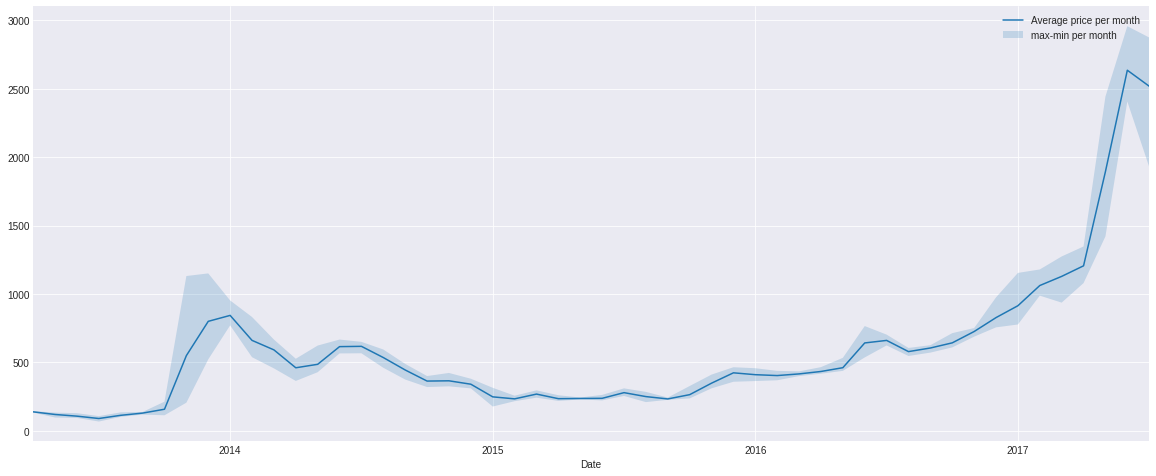

In [322]:
m = data['Close'].resample('M').agg(['mean','std','min','max'])

pyplot.figure(figsize=(20,8))
m['mean'].plot(label='Average price per month')

pyplot.fill_between(m.index,m['min'],m['max'],alpha=0.2,label='max-min per month')
pyplot.legend()
pyplot.show()

In [323]:
y_2017=data.iloc[:212]
y_2017.drop(y_2017[['Market Cap','Volume']],axis=1)

,Open,High,Low,Close
Date,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34
2017-07-30,2724.39,2758.53,2644.85,2757.18
2017-07-29,2807.02,2808.76,2692.80,2726.45
2017-07-28,2679.73,2897.45,2679.73,2809.01
2017-07-27,2538.71,2693.32,2529.34,2671.78
...,...,...,...,...
2017-01-05,1156.73,1191.10,910.42,1013.38
2017-01-04,1044.40,1159.42,1044.40,1154.73
2017-01-03,1021.60,1044.08,1021.60,1043.84


In [324]:
monthvise= y_2017.groupby(y_2017.index.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July']
monthvise = monthvise.reindex(new_order, axis=0)
monthvise

,Open,Close
Date,,
January,914.681290,914.916452
February,1055.620000,1062.533214
March,1133.212258,1129.365484
April,1197.647000,1206.641000
May,1865.748710,1895.383548
June,2630.573333,2636.204333
July,2509.213226,2519.418387


In [325]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Open'],
    name='Stock Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthvise.index,
    y=monthvise['Close'],
    name='Stock Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between Stock open and close price in 2017')
fig.show(renderer="colab")


In [326]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(y_2017, x=y_2017.index, y=[y_2017['Open'], y_2017['Close'], 
                                          y_2017['High'], y_2017['Low']],
             labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show(renderer="colab")

#Pre-processing

In [327]:
from sklearn.preprocessing import MinMaxScaler
values = data['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [328]:
scaled

array([[0.9713567 ],
       [0.9304663 ],
       [0.91983193],
       ...,
       [0.02442139],
       [0.02633855],
       [0.02276377]], dtype=float32)

In [329]:
test_size = int(len(scaled) * 0.4)
train_size = len(scaled) - test_size
train, test = scaled[test_size:,:], scaled[:test_size,:]
print(len(train), len(test))

934 622


Text(0.5, 1.0, 'Scaled Trainind Data')

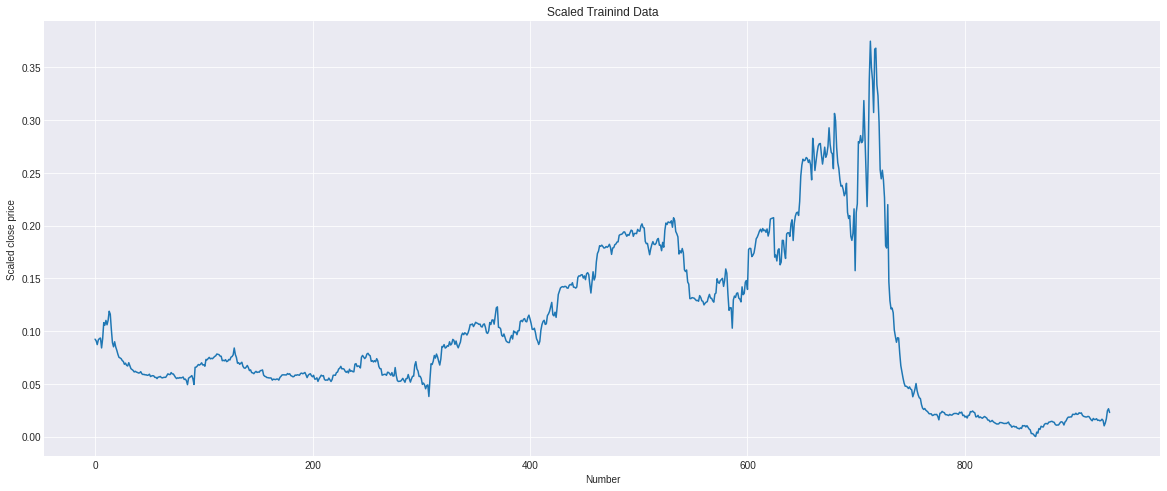

In [330]:

pyplot.figure(figsize=(20,8))
pyplot.plot(train)
pyplot.ylabel("Scaled close price")
pyplot.xlabel("Number")
pyplot.title('Scaled Trainind Data')

Text(0.5, 1.0, 'Scaled Test Data')

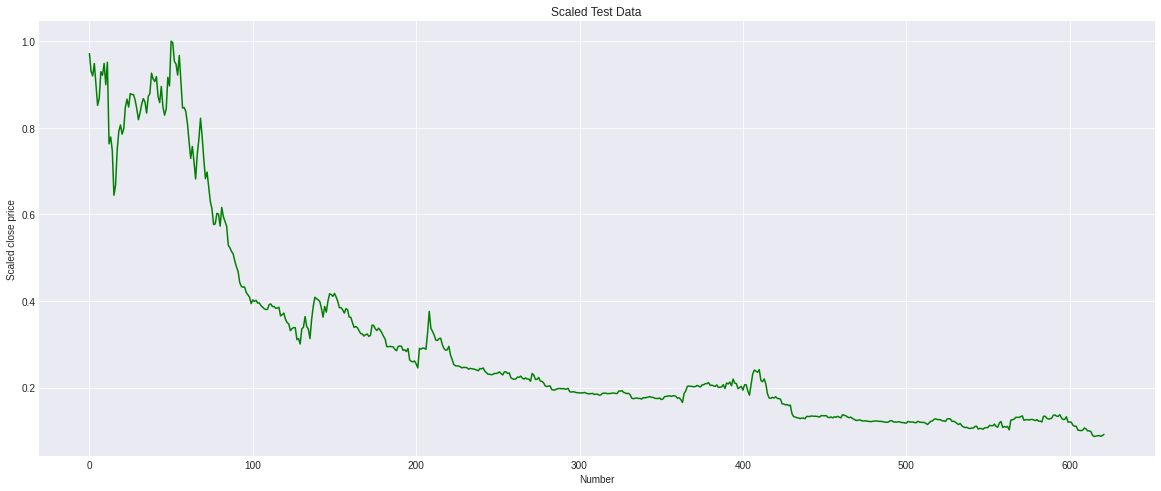

In [331]:

pyplot.figure(figsize=(20,8))
pyplot.plot(test,color='green')
pyplot.ylabel("Scaled close price")
pyplot.xlabel("Number")
pyplot.title("Scaled Test Data")

In [332]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
    

In [333]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

933
621


In [334]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#Modelling

In [335]:
trainX.shape

(933, 1, 1)

In [336]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

Traing and testing loss

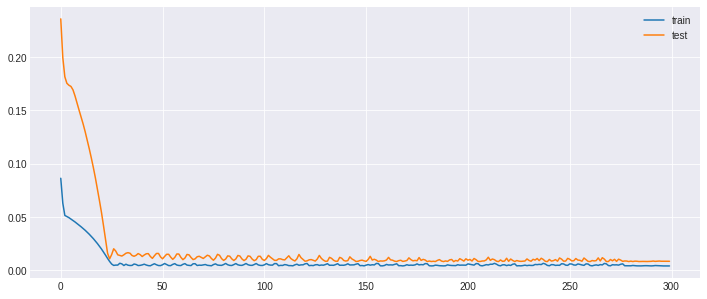

In [337]:
pyplot.figure(figsize=(12,5))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


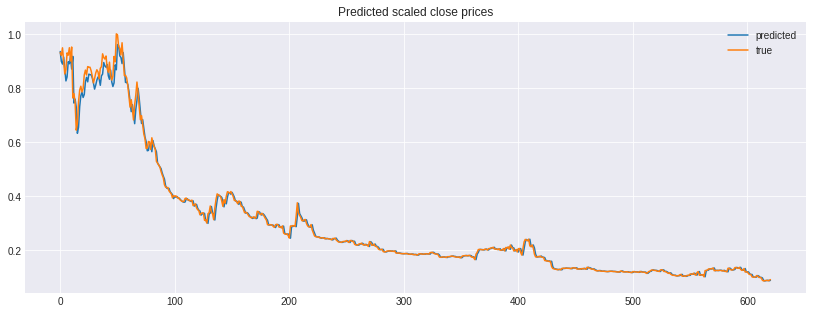

In [338]:
pyplot.figure(figsize=(14,5))
yhat = model.predict(testX)
pyplot.plot(yhat, label='predicted')
pyplot.plot(testY, label='true')
pyplot.title("Predicted scaled close prices")
pyplot.legend()
pyplot.show()

In [339]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [340]:
xhat=model.predict(trainX)

In [341]:
xhat_inverse = scaler.inverse_transform(xhat.reshape(-1, 1))
trainY_inverse = scaler.inverse_transform(trainY.reshape(-1, 1))

#Results

In [342]:
print("Mean Squared error on test set=",mean_squared_error(testY_inverse, yhat_inverse))

Mean Squared error on test set= 2792.983


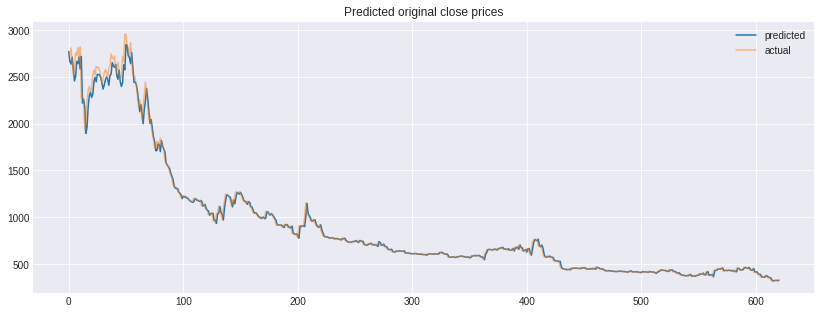

In [343]:
pyplot.figure(figsize=(14,5))
pyplot.plot(yhat_inverse, label='predicted')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.title("Predicted original close prices")
pyplot.legend()
pyplot.show()

In [344]:
from sklearn.metrics import r2_score
print("R2-score in testing set-",r2_score(testY_inverse,yhat_inverse))

R2-score in testing set- 0.9935172557875903


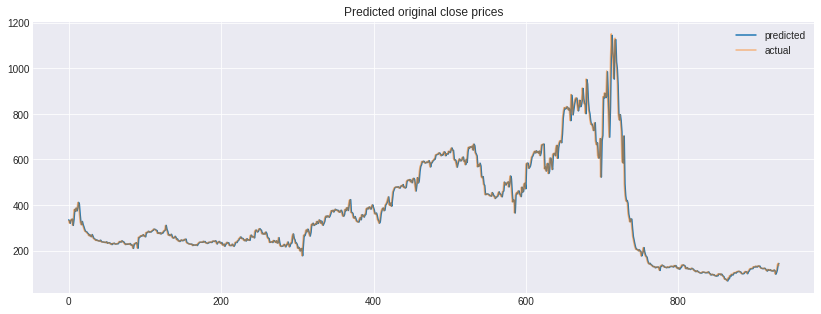

In [345]:
pyplot.figure(figsize=(14,5))
pyplot.plot(xhat_inverse, label='predicted')
pyplot.plot(trainY_inverse, label='actual', alpha=0.5)
pyplot.title("Predicted original close prices")
pyplot.legend()
pyplot.show()

In [346]:
print("Mean Squared error on training set=",mean_squared_error(trainY_inverse, xhat_inverse))

Mean Squared error on training set= 643.2286


In [347]:
print('R2-score in training set-',r2_score(trainY_inverse,xhat_inverse))

R2-score in training set- 0.9861547591692594
